In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from glob import glob
from tqdm.auto import tqdm
import re 
import math
from pathlib import Path 
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import mne
mne.set_log_level(verbose=False)
import wandb

from Datasets import *

from utils_folder.callbacks import *
from utils_folder.training_pth import *
from utils_folder.plotting import *
from utils_folder.utils import get_labels_and_preds

2021-09-04 20:16:31.543293: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def get_order(file_path):
    """
    Used to order the results from glob, so that the patients are
    properly concatenated.
    """
    match = file_pattern.match(Path(file_path).name)
    if not match:
        return math.inf
    return int(match.groups()[0])

## Load the data from the already prepared ```numpy``` arrays.

In [4]:
## Define the regex to sort the files and obtain the paths list
file_pattern = re.compile(r'.*?(\d+).*?')
sorted_files = sorted(glob("/home/pabloro/master/datos_PSG*.npy"), key=get_order)
### Remove the 10th patient
sorted_files_no_10 = [a for a in sorted_files if re.findall(r'\d+', a)[0]!='10']

## Load the data
data = [np.load(path_glob) for path_glob in tqdm(sorted_files_no_10)]
data = np.concatenate(data)

  0%|          | 0/19 [00:00<?, ?it/s]

In [5]:
## Define the regex to sort the files and obtain the paths list
file_pattern = re.compile(r'.*?(\d+).*?')
sorted_files = sorted(glob("/home/pabloro/master/Etiquetas_PSG*.csv"), key=get_order)
### Remove the 10th patient
sorted_files_no_10 = [a for a in sorted_files if re.findall(r'\d+', a)[0]!='10']

## Load the labels
labels = [pd.read_csv(path_glob).to_numpy().squeeze() for path_glob in tqdm(sorted_files_no_10)]
labels = np.concatenate(labels)

## Encode the labels
le = LabelEncoder()
le.fit(labels)
labels_encoded = le.transform(labels)

  0%|          | 0/19 [00:00<?, ?it/s]

In [6]:
data.shape, labels_encoded.shape

((15041, 15360, 9), (15041,))

## Separate train-val-test.

In [7]:
idx_train = np.loadtxt("../indices_train.txt").astype(int)
idx_val = np.loadtxt("../indices_val.txt").astype(int)
idx_test = np.loadtxt("../indices_test_2.txt").astype(int)

In [8]:
X_train, Y_train = data[idx_train], labels_encoded[idx_train]
X_val, Y_val = data[idx_val], labels_encoded[idx_val]
X_test, Y_test = data[idx_test], labels_encoded[idx_test]

In [9]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((9776, 15360, 9),
 (9776,),
 (2632, 15360, 9),
 (2632,),
 (2633, 15360, 9),
 (2633,))

In [10]:
sampling_rate = 512

In [37]:
def create_simple_model(sampling_rate=512, classes=5):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(128, kernel_size=sampling_rate//2, strides=sampling_rate//4, activation="relu", input_shape=(15360,9)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [33]:
def create_scaled_data(train, val, test):
    def _create_scaled_data(data):
        ## Create different data
        data_std = (data - mean)/std
        data_norm = data / np.abs(data).max(axis=1).max(axis=0)
        data_norm_std = (data_norm - data_norm.mean(axis=1).mean(axis=0))/data_norm.std(axis=1).mean(axis=0)
        data_norm_nomean = (data_norm - data_norm.mean(axis=1).mean(axis=0))

        ## Put them into a dictionary so its more clean
        scaled_data = {
            "Raw Data":data,
            "Standarized Data":data_std,
            "Normalized Data":data_norm,
            "Normalized and Standarized Data":data_norm_std,
            "Normalized and Mean Substracted Data":data_norm_nomean
        }

        return scaled_data

    ## Obtain mean and std
    mean = train.mean(axis=1).mean(axis=0)
    std = train.std(axis=1).mean(axis=0)

    ## Create different data
    scaled_train = _create_scaled_data(train)
    scaled_val = _create_scaled_data(val)
    scaled_test = _create_scaled_data(test)

    return scaled_train, scaled_val, scaled_test

In [41]:
def train_scaled_data(scaled_data_train, scaled_data_val, labels_train, labels_val, epochs=50, n_classes=5):
    histories = {}

    ## Train a model for each different scaled data and store the History object
    for name, data in tqdm(scaled_data_train.items()):
        data_val = scaled_data_val[name]
        model = create_simple_model(512, n_classes)
        history = model.fit(data, labels_train, batch_size=256, epochs=epochs, verbose=0, 
                            validation_data=(data_val, labels_val))
        histories[name] = history
    
    return histories

In [47]:
def plot_histories(histories, n_patients):    
    plt.figure(figsize=(16,12))
    plt.suptitle(f"{n_patients} Patients")
    ## Train
    plt.subplot(2,2,1)
    plt.title("Train Loss")

    for i, (name, history) in enumerate(histories.items()):
        plt.plot(history.history["loss"], label=name)

    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    ## Validation
    plt.subplot(2,2,2)
    plt.title("Validation Loss")

    for i, (name, history) in enumerate(histories.items()):
        plt.plot(history.history["val_loss"], label=name)

    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    ## Train
    plt.subplot(2,2,3)
    plt.title("Train Accuracy")

    for i, (name, history) in enumerate(histories.items()):
        plt.plot(history.history["accuracy"], label=name)

    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    # Validation
    plt.subplot(2,2,4)
    plt.title("Validation Accuracy")

    for i, (name, history) in enumerate(histories.items()):
        plt.plot(history.history["val_accuracy"], label=name)

    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")


    plt.show()

In [34]:
X_scaled_train, X_scaled_val, X_scaled_test = create_scaled_data(X_train, X_val, X_test)

In [40]:
X_scaled_train['Raw Data'].shape

(9776, 15360, 9)

  0%|          | 0/5 [00:00<?, ?it/s]

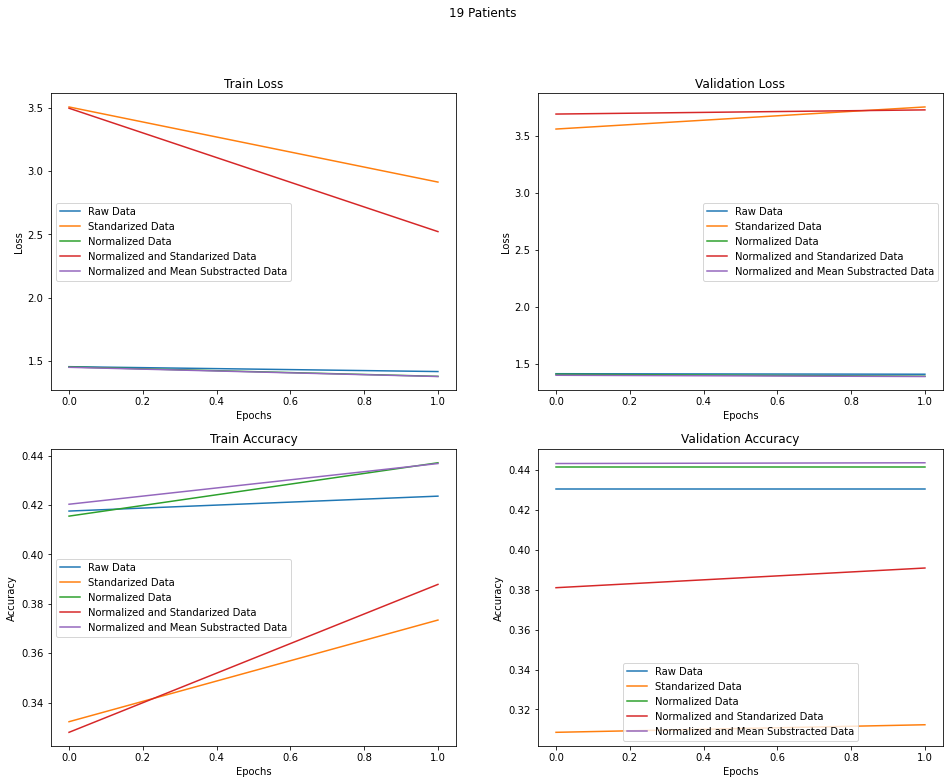

In [49]:
histories = train_scaled_data(X_scaled_train, X_scaled_val, Y_train, Y_val, epochs=100, n_classes=5)
plot_histories(histories, len(sorted_files_no_10))